<a href="https://colab.research.google.com/github/HuyenNguyenHelen/INFO-5505---Machine-learning/blob/main/HuyenNguyen_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Text classification - Naive Bayes
**Dataset**: [Customer reviews](http://www.cse.chalmers.se/~richajo/dit862/data/all_sentiment_shuffled.txt)

**Goals**: Implementing the Naive Bayes classification method and use it for sentiment classification of customer reviews


## Loading data
The original dataset is formatted in .txt, we will reformat and store data into dataframe for our convenience.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Getting data from url
import base64
import requests
re = requests.get ('http://www.cse.chalmers.se/~richajo/dit862/data/all_sentiment_shuffled.txt')
data = re.text

## Data Preprocessing

### Reformatting the Data

In [3]:
# Printing data type and observe the original format of the data
print("data's type:  ", type(data))
print(data[:100])

data's type:   <class 'str'>
music neg 241.txt i bought this album because i loved the title song . it 's such a great song , how


The original data is in the string data type with one review per line. We can split these reviews and reformat into the data dataframe type.

In [4]:
# Reformatting the data

# Separating the data into its four data attributes: reviews, topics, labels, and documment ids
# Creating empty lists of 4 data attributes
reviews, topics, labels, doc_id = [],[],[],[]
# Looping over lines to separate them into reviews, topics, labels, and documment ids
for line in data.splitlines():
  reviews.append(' '.join(token for token in line.split()[3:]))
  topics.append(line.split()[0])
  labels.append(line.split()[1])
  doc_id.append(line.split()[2])

# Storing the separated data into dataframe
df = pd.DataFrame(zip(doc_id, reviews, topics, labels), columns = ['doc_id', 'review', 'topic', 'label'])
print("data's shape: ", df.shape)
df.head()

data's shape:  (11914, 4)


,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,neg
1,544.txt,i was misled and thought i was buying the enti...,music,neg
2,729.txt,"i have introduced many of my ell , high school...",books,neg
3,278.txt,anything you purchase in the left behind serie...,books,pos
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,pos


### Exploring the dependent variable

data distribution in the dependent variable:
 pos    6000
neg    5914
Name: label, dtype: int64


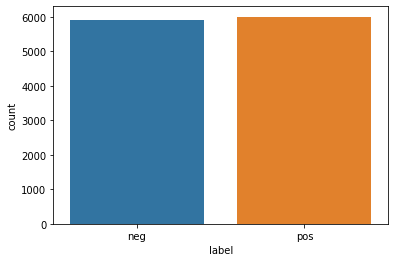

In [5]:
print('data distribution in the dependent variable:\n', df['label'].value_counts())
sns.countplot(data = df, x = 'label')
plt.show()

In [6]:
# Encoding the target labels into the numeric type
df['label'] = np.where(df['label']=='pos', 1, 0)
df.head()

,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,0
1,544.txt,i was misled and thought i was buying the enti...,music,0
2,729.txt,"i have introduced many of my ell , high school...",books,0
3,278.txt,anything you purchase in the left behind serie...,books,1
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,1


### Cleaning data
When doing text classification, data cleaning is an essential part, deciding the model's performance. Some stopwords such as 'the','a', etc. occur most frequently, but contain no useful information. We expect to remove these words from the corpus. We will also remove punctuations. 

In [7]:
# Downloading a stopword list in English
!pip install stop-words
from stop_words import get_stop_words
stop_words = get_stop_words('en')

In [8]:
# Cleaning the reviews
# Removing stopwords, and numerics 
df['review'] = df['review'].apply( lambda x: ' '.join(x for x in str(x).split() if not x.isdigit() and not x.isspace() ) )
df['review'] = df['review'].apply( lambda x: ' '.join(x for x in str(x).split() if x not in stop_words) )
# Removing punctuations and non-letter tokens
df['review']=df['review'].str.replace('[^\w\s]','') # remove punctuations
df['review'].head()

0    bought album loved title song  s great song  b...
1    misled thought buying entire cd contains one song
2    introduced many ell  high school students lois...
3    anything purchase left behind series excellent...
4    loved movies  cant wiat third one  funny  suit...
Name: review, dtype: object

## Developping model

In [9]:
# Representing the review corpus by vector
from sklearn.feature_extraction.text import CountVectorizer
# Creating a vectorizer model that convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(lowercase = False)
# Fitting the vectorizer model to transform words to vectors
features = vectorizer.fit_transform(df['review'])
# convert sparse matrix to a dense matrix
features_dm = features.toarray()


In [10]:
print('The number of features: ', len(vectorizer.get_feature_names()))

The number of features:  53455


In [11]:
# Observing the documment term-matrix
pd.DataFrame(features_dm, columns = vectorizer.get_feature_names())

,00,000,00000,000feet,000mb,000page,000steps,004144php,01,010,02071982,03051983,039,04,04111981,044,05,06,0611,07,074,08,0s,10,100,1000,10000,100000,10000i,1000mg,1000the,100120,100200,100300,100300mm,100400,100400mm,100asa,100g,100k,...,zoos,zoot,zora,zorn,zowie,zr,zr10,zr500,zr800,zr850,zr85mc,ztrip,zucas,zucchero,zuckermann,zukav,zulu,zutons,zuz,zuzu,zydeco,zyr,zz,zzzzz,zzzzzzzzzzz,Âpor,ÂquÃ,Â¼,Â½,Ãa,Ãnnui,Ãron,ÃrpÃd,Ãºnico,ÃÂÂ½50,ÃÂÂ½bersoldier,ÃÂÂ½bersoldiers,ÃÂÂ½kerlund,ÃÂÂ½lan,ÃÂÂ½vis
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = features_dm
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (9531, 53455) (9531,)
Shapes of X_test, y_test:  (2383, 53455) (2383,)


In [13]:
# Creating a naive bayes models for text classification
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# Fitting the model into the training set for learning
#mnb.fit(X_train, y_train)

In [ ]:
# Traininng and validating the moel using k-fold cross validation
from sklearn.model_selection import cross_validate
cv = cross_validate (mnb, X_train, y_train, cv = 10)
print("accuracy score of 10-fold cross validation:\n", cv['test_score'])
print("cross validation accuracy mean score: \n", cv['test_score'].mean())


In [14]:
# Applying the learned model to make prediction on the test set
y_pred = mnb.predict(X_test)

In [15]:
# Evaluating the model
print('Accuracy of the selected model in the test set: {:.4f}'.format(mnb.score(X_test, y_test)))

Accuracy of the selected model in the test set: 0.8028
